# Data, Libraries & Settings

#### Libraries

In [1]:
# Data manipulation libs
import pandas as pd
import numpy as np
from tabulate import tabulate
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

#### Settings

In [2]:
# Plot settings
line_width = 0.75

# Print all columns from pandas df
pd.set_option('max_columns', None)

#### Subject Data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
print(os.listdir('/content/drive/MyDrive/cdl_data'))

['data_subjects_info.csv', 'A_DeviceMotion_data']


In [9]:
# Get subjects info
subjects_information_df = pd.read_csv('/content/drive/MyDrive/cdl_data/data_subjects_info.csv')
'''
Column  Attribute         [Unit]
Code:   subject ID        [1 to 24]
Weight: Weight of subject [Kg.]
Height: Weight of subject [Cm.]
Age:    Age of subject    [Years]
Gender: Gender of subject [0: F, 1: M]
'''
subjects_information_df.head(3)

,code,weight,height,age,gender
0,1,102,188,46,1
1,2,72,180,28,1
2,3,48,161,28,0


#### Test Data

The test data was collected during these 6 trials:
- Downstairs $\;$[dws]
- Upstairs   $\;$[ups]
- Walking    $\;$[wlk]
- Jogging    $\;$[jog]
- Sitting    $\;$[sit]
- Standing   $\;$[std]

In [10]:
'''
Dictionary to specify file numbers of trials so all data can be loaded
'''
trial_id_dict = {
    'dws': [1, 2, 11],
    'ups': [3, 4, 12],
    'wlk': [7, 8, 15],
    'jog': [9, 16],
    'sit': [5, 13],
    'std': [6, 14]
}

'''
Get dictionary for all gyroscopic measurements
'''
measurement_dict = {
    'attitude': ['attitude.roll', 'attitude.pitch', 'attitude.yaw'],
    'gravity':  ['gravity.x', 'gravity.y', 'gravity.z'],
    'rotationRate': ['rotationRate.x', 'rotationRate.y', 'rotationRate.z'],
    'userAcceleration': ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
}

'''
Specify number of subjects and list of subject numbers
*Assumes the subject ID's go from 1 to n incremented by 1*
'''
subject_number = 24
subject_id_lst = list(range(1, subject_number+1))
'''
Get folder location with test data
'''
test_data = '/content/drive/MyDrive/cdl_data/A_DeviceMotion_data/'

In [11]:
# Init all_data_dictionary for storing all dataframes
all_data_dictionary = {}

# Init start_date for creating time_series_data in data load loop
start_date = '01/01/2022'
start_datetime = datetime.datetime.strptime(start_date, '%m/%d/%Y')

'''
Fill all_data_dictionary with dataframes from each trial
'''
for key in trial_id_dict:
    # Init pandas dataframe for each key
    all_data_dictionary[key] = pd.DataFrame()
    for subject_id in subject_id_lst:
        for test_numbers in trial_id_dict[key]:
            # Read in data from file
            temp_df = pd.read_csv(f'{test_data}{key}_{test_numbers}/sub_{subject_id}.csv').iloc[:, 1:]
            # Add trial number, subject ID, and test type
            temp_df['test_type'] = key
            temp_df['subject_id'] = subject_id
            temp_df['test_trial_number'] = test_numbers
            # Append data to dataframe in dict
            all_data_dictionary[key] = pd.concat([all_data_dictionary[key], temp_df])
    '''
    Reset index of each df
    Rename first column to tick_num
    Calculate time since beginning of trial in seconds
    Get time series column
    Get magnitude [(x^2+y^2+z^2)^(1/2)] for gyro variable
    Join subject data
    ''' 
    all_data_dictionary[key] = all_data_dictionary[key].reset_index()
    all_data_dictionary[key] = all_data_dictionary[key].rename(columns={'index': 'tick_num'})
    all_data_dictionary[key]['time_since_start'] = (all_data_dictionary[key]['tick_num']/50)
    all_data_dictionary[key]['time_series_data'] = start_datetime + pd.to_timedelta(all_data_dictionary[key]['time_since_start'], unit='s')

    for measurement in measurement_dict:
        m_temp = measurement_dict[measurement]
        x_2 = all_data_dictionary[key][m_temp[0]]**2
        y_2 = all_data_dictionary[key][m_temp[1]]**2
        z_2 = all_data_dictionary[key][m_temp[2]]**2
        all_data_dictionary[key][measurement] = (x_2+y_2+z_2)**(1/2)
    all_data_dictionary[key] = all_data_dictionary[key].join(subjects_information_df.set_index('code'), on = 'subject_id')

In [19]:
def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("/content/drive/MyDrive/cdl_data/data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = '/content/drive/MyDrive/cdl_data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "gravity", "rotationRate", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'gravity', 'rotationRate', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 19)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


In [20]:
dataset

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412860,-2.368280,-0.381075,-0.089417,-0.648402,0.371919,0.664267,-0.001312,-0.011512,0.001284,0.000789,-0.005937,-0.004355,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412861,-2.368752,-0.381071,-0.089478,-0.648090,0.371915,0.664574,-0.000293,-0.022169,0.001305,-0.000409,-0.000608,0.000098,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412862,-2.369130,-0.381163,-0.089465,-0.647814,0.372000,0.664795,0.007208,-0.012616,0.003482,-0.000486,0.000711,0.002045,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412863,-2.369372,-0.381295,-0.089468,-0.647619,0.372123,0.664916,0.006180,-0.003029,0.004531,0.000311,-0.003395,0.004746,5.0,23.0,74.0,173.0,18.0,0.0,13.0


In [12]:
# A dataframe exists for each key in the all_data_dictionary dictionary
all_data_dictionary['dws'].head(4)

,tick_num,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,test_type,subject_id,test_trial_number,time_since_start,time_series_data,attitude,gravity,rotationRate,userAcceleration,weight,height,age,gender
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,dws,1,1,0.00,2022-01-01 00:00:00.000,1.832682,1.0,1.370498,0.513360,102,188,46,1
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,dws,1,1,0.02,2022-01-01 00:00:00.020,1.818843,1.0,1.141648,0.250235,102,188,46,1
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,dws,1,1,0.04,2022-01-01 00:00:00.040,1.812205,1.0,0.372530,0.215450,102,188,46,1
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,dws,1,1,0.06,2022-01-01 00:00:00.060,1.803822,1.0,1.049628,0.166728,102,188,46,1


In [13]:
# Create dataframe with all data
df_all_data = pd.DataFrame()
for key in all_data_dictionary:
  df_all_data = pd.concat([df_all_data, all_data_dictionary[key]])

In [14]:
df_all_data

,tick_num,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,test_type,subject_id,test_trial_number,time_since_start,time_series_data,attitude,gravity,rotationRate,userAcceleration,weight,height,age,gender
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,dws,1,1,0.00,2022-01-01 00:00:00.000,1.832682,1.0,1.370498,0.513360,102,188,46,1
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,dws,1,1,0.02,2022-01-01 00:00:00.020,1.818843,1.0,1.141648,0.250235,102,188,46,1
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,dws,1,1,0.04,2022-01-01 00:00:00.040,1.812205,1.0,0.372530,0.215450,102,188,46,1
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,dws,1,1,0.06,2022-01-01 00:00:00.060,1.803822,1.0,1.049628,0.166728,102,188,46,1
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,dws,1,1,0.08,2022-01-01 00:00:00.080,1.783334,1.0,0.921229,0.408720,102,188,46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306422,3964,-2.512274,-1.475547,0.560892,-0.055978,0.995467,0.076886,-0.048465,0.019469,0.001242,-0.000006,0.003480,0.003391,std,24,14,79.28,2022-01-01 00:01:19.280,2.967046,1.0,0.052244,0.004859,74,173,18,0
306423,3965,-2.514569,-1.474699,0.558068,-0.056297,0.995386,0.077698,-0.048469,0.012038,-0.005159,-0.007363,0.001165,-0.003677,std,24,14,79.30,2022-01-01 00:01:19.300,2.968035,1.0,0.050207,0.008312,74,173,18,0
306424,3966,-2.517105,-1.473640,0.555248,-0.056716,0.995284,0.078696,-0.045221,0.015253,-0.012618,-0.003800,-0.004638,0.001978,std,24,14,79.32,2022-01-01 00:01:19.320,2.969130,1.0,0.049364,0.006314,74,173,18,0
306425,3967,-2.515195,-1.472593,0.557282,-0.057477,0.995182,0.079431,-0.034644,-0.016695,-0.024255,-0.007647,-0.005009,-0.001688,std,24,14,79.34,2022-01-01 00:01:19.340,2.967372,1.0,0.045467,0.009296,74,173,18,0


In [15]:
# Get data for each trial individually
dict_individual_trials = {}
for key in trial_id_dict:
    for subject_id in subject_id_lst:
        for test_numbers in trial_id_dict[key]:
          dict_individual_trials[f"trial: {key} sbj: {str(subject_id)} tst_no: {str(test_numbers)}"] = df_all_data[(df_all_data.subject_id == subject_id) & (df_all_data.test_type == key) & (df_all_data.test_trial_number == test_numbers)]

In [16]:
print(f"Sample key for dictionary above: {list(dict_individual_trials.keys())[0]}")

Sample key for dictionary above: trial: dws sbj: 1 tst_no: 1


In [ ]:
df_all_data.groupby(['time_series_data']).apply(lambda x: x['value'].tolist())

KeyError: ignored

In [ ]:
# Get padded sequences

# Init sequences list
sequences = []
y_values = []

# loop through each trial dataframe from the dict_individual_trials dict and append the values of the time_since_start column to sequences
for trial in dict_individual_trials:
  sequences.append(list(dict_individual_trials[trial]['attitude'].values))
  y_values.append(list(dict_individual_trials[trial]['test_type'])[0])

# Get the max sequence length
max_length = max([len(s) for s in sequences])

# Pad the sequences data to the same length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Labels
le = LabelEncoder()
le.fit(y_values)
y_int = le.transform(y_values)
y_categorical = to_categorical(y_int)
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y_categorical, test_size=0.2)

In [ ]:
# define the model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Epoch 1/5


ValueError: ignored

# EDA

In [ ]:
# Write data to CSV for tableau
# for dataframe in all_data_dictionary:
#     all_data_dictionary[dataframe].to_csv(f'{dataframe}.csv', index=False)

In [ ]:
# Check for null values
null_checks = sum([all_data_dictionary[dataframe].isnull().values.any() for dataframe in all_data_dictionary])
if null_checks > 0:
    print("There are null values")
else:
    print("There are no null values")

There are no null values


#### Plot sample acceleration

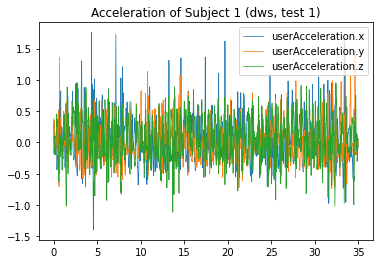

In [ ]:
# Plot settings
line_width = 0.75

# Get data (subject 1, downstairs, trial 1)
dws_test1_user1 = all_data_dictionary['dws']
dws_test1_user1 = dws_test1_user1[(dws_test1_user1['subject_id'] == 1) & (dws_test1_user1['test_trial_number'] == 1)]

x = dws_test1_user1['time_since_start']
y1 = dws_test1_user1['userAcceleration.x']
y2 = dws_test1_user1['userAcceleration.y']
y3 = dws_test1_user1['userAcceleration.z']

plt.plot(x, y1, label = "userAcceleration.x", linewidth=line_width)
plt.plot(x, y2, label = "userAcceleration.y", linewidth=line_width)
plt.plot(x, y3, label = "userAcceleration.z", linewidth=line_width)
plt.title("Acceleration of Subject 1 (dws, test 1)")
plt.legend(loc="best")
plt.show()

### Checking for extreme values

In [ ]:
'''
Get min and max for each dataframe in all_data_dictionary
Store min and max in new dictionary
tabulate results of each trial type
'''
measures = measurement_dict.keys()
min_max_data_dict = {}
for measurement in measures:
    min_max_data_dict[measurement] = {}
    for dataframe in all_data_dictionary:
        temp_lst = list(all_data_dictionary[dataframe][measurement])
        min_max_data_dict[measurement][dataframe] = (round(min(temp_lst), 5), round(max(temp_lst), 5), round(np.mean(temp_lst), 5))
    print(f'###################### Min/Max/Mean {measurement} ##########################')
    headers = ["Action Type", f"Min {measurement}", f"Max {measurement}", f"Mean {measurement}"]
    print(tabulate([(k,) + v for k,v in min_max_data_dict[measurement].items()], headers = headers))

###################### Min/Max/Mean attitude ##########################
Action Type      Min attitude    Max attitude    Mean attitude
-------------  --------------  --------------  ---------------
dws                   0.75927         4.64535          2.51448
ups                   0.29238         4.65211          2.55148
wlk                   0.54617         4.67095          2.24519
jog                   0.59719         4.68484          2.58972
sit                   0.00311         3.84029          1.52589
std                   1.2975          4.67603          2.7547
###################### Min/Max/Mean gravity ##########################
Action Type      Min gravity    Max gravity    Mean gravity
-------------  -------------  -------------  --------------
dws                  0.99997              1         1
ups                  0.99997              1         1
wlk                  0.99995              1         0.99999
jog                  0.99996              1         1
sit         

Does not seem to be any extreme values present (Lucky)

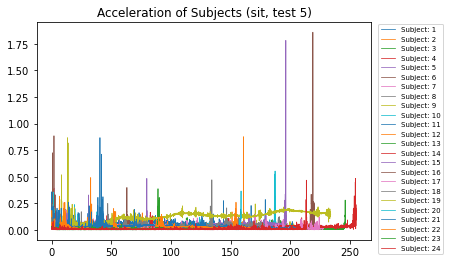

In [ ]:
# Plot settings
fontsize = 7
line_width = 0.75
test_name = 'sit'
df_temp = all_data_dictionary[test_name]
df_temp[['subject_id', 'userAcceleration']]
temp_trial_number = list(df_temp['test_trial_number'].unique())[0]

for subject in range(1, subject_number+1):
    temp_df = df_temp[(df_temp['subject_id'] == subject) & (df_temp['test_trial_number'] == temp_trial_number)]
    
    x = temp_df['time_since_start']
    y = temp_df['userAcceleration']

    plt.plot(x, y, label = str(f"Subject: {subject}"), linewidth=line_width)
plt.title(f"Acceleration of Subjects ({test_name}, test {temp_trial_number})")
plt.legend(loc="best", fontsize=fontsize, bbox_to_anchor=(1.01, 1.01))
plt.show()

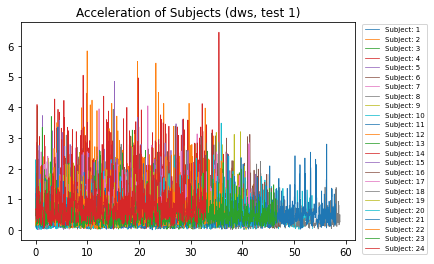

In [ ]:
# Plot settings
fontsize = 7
line_width = 0.75
test_name = 'dws'
df_temp = all_data_dictionary[test_name]
df_temp[['subject_id', 'userAcceleration']]
temp_trial_number = list(df_temp['test_trial_number'].unique())[0]

for subject in range(1, subject_number+1):
    temp_df = df_temp[(df_temp['subject_id'] == subject) & (df_temp['test_trial_number'] == temp_trial_number)]
    
    x = temp_df['time_since_start']
    y = temp_df['userAcceleration']

    plt.plot(x, y, label = str(f"Subject: {subject}"), linewidth=line_width)
plt.title(f"Acceleration of Subjects ({test_name}, test {temp_trial_number})")
plt.legend(loc="best", fontsize=fontsize, bbox_to_anchor=(1.01, 1.01))
plt.show()

# Modeling

In [ ]:
list(df_all_data.columns)

['tick_num',
 'attitude.roll',
 'attitude.pitch',
 'attitude.yaw',
 'gravity.x',
 'gravity.y',
 'gravity.z',
 'rotationRate.x',
 'rotationRate.y',
 'rotationRate.z',
 'userAcceleration.x',
 'userAcceleration.y',
 'userAcceleration.z',
 'test_type',
 'subject_id',
 'test_trial_number',
 'time_since_start',
 'time_series_data',
 'attitude',
 'gravity',
 'rotationRate',
 'userAcceleration',
 'weight',
 'height',
 'age',
 'gender']

In [ ]:
# Define data for LSTM

# columns_BI_LSTM = [
#     'attitude.roll',
#     'attitude.pitch',
#     'attitude.yaw',
#     'gravity.x',
#     'gravity.y',
#     'gravity.z',
#     'rotationRate.x',
#     'rotationRate.y',
#     'rotationRate.z',
#     'userAcceleration.x',
#     'userAcceleration.y',
#     'userAcceleration.z',
#     'test_type',
#     'subject_id',
#     'test_trial_number',
#     'time_since_start',
#     'time_series_data',
#     'attitude',
#     'gravity',
#     'rotationRate',
#     'userAcceleration',
#     'weight',
#     'height',
#     'age',
#     'gender'
# ]

columns_BI_LSTM_test = [
    'attitude.roll',
    'attitude.pitch',
    'attitude.yaw',
    'gravity.x',
    'gravity.y',
    'gravity.z',
    'rotationRate.x',
    'rotationRate.y',
    'rotationRate.z',
    'userAcceleration.x',
    'userAcceleration.y',
    'userAcceleration.z'
]

data_Bidirectional_LSTM = df_all_data[columns_BI_LSTM_test]

# Extra Code Saved for Later

In [ ]:
# Preprocess the data
data = ...  # Load the data into a dataframe
data = data.pivot(index='time', columns='series', values='value')  # Transform the data into a series of rows, each of which represents a time step and contains the values for all time series at that time step
data = (data - data.mean()) / data.std()  # Normalize the data

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data.values[:, :-1], data.values[:, -1], test_size=0.2, random_state=42)

import pandas as pd

# Create a dataframe from the data
df = pd.DataFrame(data)

# Use the groupby function to group the data by time and series, and apply a function to the data in each group
df_grouped = df.groupby(['time', 'series']).apply(lambda x: x['value'].tolist())

# Unstack the data to transform it into a series of rows, each of which represents a time step and contains the values for all time series at that time step
df_unstacked = df_grouped.unstack()

print(df_unstacked)

         value                           
series       A       B       C           
time                                     
1       [1, 2]  [3, 4]     NaN           
2       [5]     [6]     [7]             
3       [8]     NaN     [9]

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Transform the data into a series of rows, each of which represents a time step and contains the values for all time series at that time step
data = df_unstacked.fillna(0).applymap(lambda x: x[0] if x else x)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data.values[:, :-1], data.values[:, -1], test_size=0.2, random_state=42)

# Define and compile the model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Evaluate the model
score = model.evaluate(X_test, y_test, batch_size=32)
print(f'Test loss: {score}')

# Make predictions on new data
predictions = model.predict(X_new)